In [177]:
# ═══════════════════════════════════════════════════════════════
# FICHE 1 : MODÈLE ARIMA (AutoRegressive Integrated Moving Average)
# ═══════════════════════════════════════════════════════════════
# ARIMA = Modèle pour séries temporelles stationnaires
#
# STATIONNARITÉ
#   Stationnaire     : E[X] constante, Var constante, Cov stable
#   Non-stationnaire : E[X] variable, Var(t), Cov variable
#   Test : ACF décroît lentement → non-stationnaire → différencier
#
# COMPOSANTES
#   AR (p) : Le futur dépend du passé (autorégressif)
#   I  (d) : Différenciation pour rendre stationnaire
#   MA (q) : Correction avec erreurs passées
#
# TROUVER (p, d, q)
#   p → PACF (coupe après lag p)
#   d → Test ADF (p>0.05 → d=1, sinon d=0)
#   q → ACF (coupe après lag q)
#
# MODÈLES COURANTS EN FINANCE
#   ARIMA(1,0,0) → Returns stationnaires simples
#   ARIMA(0,1,0) → Random walk (prix)
#   ARIMA(1,1,1) → Modèle équilibré standard
#   ARIMA(2,1,2) → Séries complexes
# ═══════════════════════════════════════════════════════════════

# ═══════════════════════════════════════════════════════════════
# FICHE 2 : AUTOCORRÉLATION (ACF)
# ═══════════════════════════════════════════════════════════════
# ACF = Corrélation entre Xt et Xt-k (totale, avec effets indirects)
# ρ(k) = Corr(Xt, Xt-k) ∈ [-1, 1]
#
# INTERPRÉTATION
#   ρ = +1 : Corrélation parfaite positive
#   ρ = 0  : Pas de corrélation
#   ρ = -1 : Corrélation parfaite négative
#
# PATTERNS ACF
#   Décroissance lente       → Non-stationnaire
#   Pic lag 1 puis chute     → AR(1)
#   Oscillations             → Saisonnalité
#   Bruit blanc              → Pas de structure
#
# UTILITÉ
#   ✓ Tester stationnarité
#   ✓ Identifier q (MA order)
#   ✓ Vérifier résidus du modèle
#   ✓ Détecter saisonnalité
#
# CODE
#   from statsmodels.graphics.tsaplots import plot_acf
#   plot_acf(series, lags=30)
# ═══════════════════════════════════════════════════════════════

# ═══════════════════════════════════════════════════════════════
# FICHE 3 : AUTOCORRÉLATION PARTIELLE (PACF)
# ═══════════════════════════════════════════════════════════════
# PACF = Corrélation directe entre Xt et Xt-k (sans effets intermédiaires)
# Différence : ACF = totale / PACF = directe uniquement
#
# PATTERNS PACF
#   Coupure nette après lag p    → AR(p)
#   Décroissance exponentielle   → MA(q)
#   Oscillations amorties        → ARMA mixte
#   Tous lags non-significatifs  → Bruit blanc
#
# ACF vs PACF : IDENTIFIER (p, q)
#   AR(p)      : ACF décroît  / PACF coupe à p
#   MA(q)      : ACF coupe à q / PACF décroît
#   ARMA(p,q)  : Les deux décroissent
#
# RÈGLE PRATIQUE
#   p (AR) → Regarde où PACF coupe
#   q (MA) → Regarde où ACF coupe
#
# UTILITÉ
#   ✓ Identifier ordre p du modèle AR
#   ✓ Distinguer AR vs MA
#   ✓ Optimiser paramètres ARIMA
#
# CODE
#   from statsmodels.graphics.tsaplots import plot_pacf
#   plot_pacf(series, lags=30)
#   
#   # Les deux ensemble
#   fig, axes = plt.subplots(1, 2, figsize=(12,4))
#   plot_acf(series, lags=30, ax=axes[0])
#   plot_pacf(series, lags=30, ax=axes[1])
# ═══════════════════════════════════════════════════════════════

In [10]:
#Lets code ARIMA MODEL
#Process : 1. Visualize the time series data 
# 2. Make the time series data stationary
# 3. Plot the correlation and autocorrelation charts
# 4. construct the ARIMA model
# 5. Use the model to make predictions

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [28]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [29]:
#rename

df.columns = ['Month', 'Milk in pounds per cow']
df.tail()

,Month,Milk in pounds per cow
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [30]:
df.drop(168, axis=0, inplace=True)

In [31]:
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Milk in pounds per cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


In [32]:
df.set_index('Month', inplace=True)


In [33]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [34]:
df.describe()

,Milk in pounds per cow
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


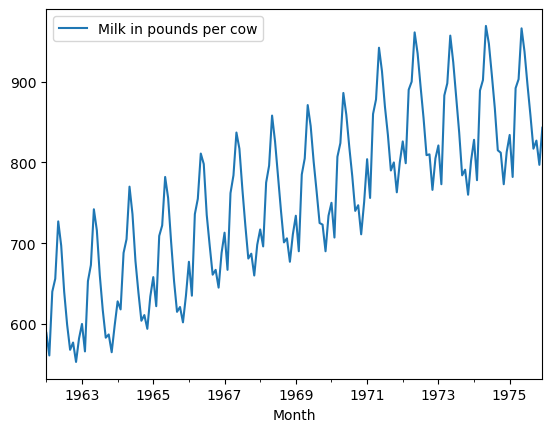

In [35]:
#step 2 

df.plot()
plt.show()

In [36]:
time_series = df['Milk in pounds per cow']

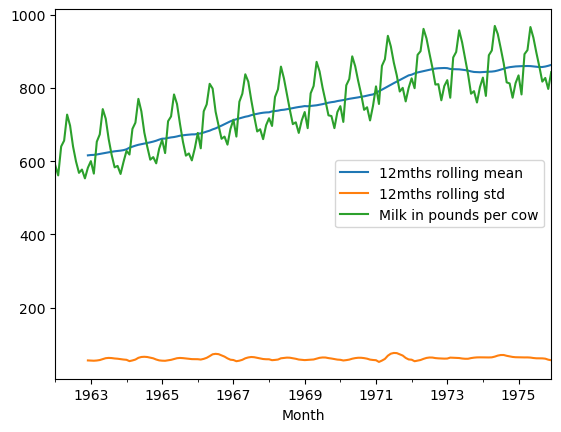

In [41]:
time_series.rolling(12).mean().plot(label='12mths rolling mean')
time_series.rolling(12).std().plot(label='12mths rolling std')
time_series.plot()
plt.legend()
plt.show()


In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose


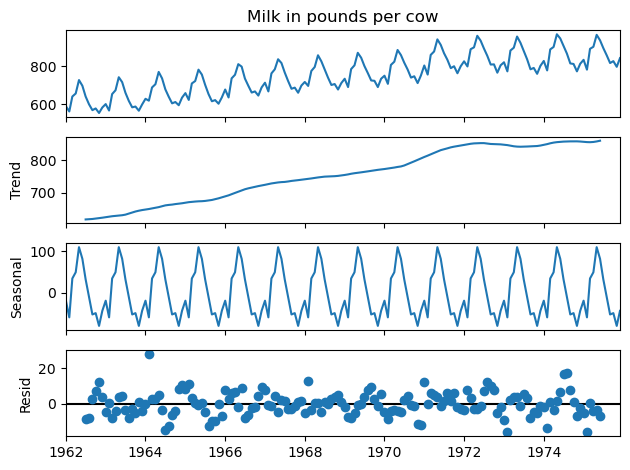

In [48]:
decomp = seasonal_decompose(time_series)
decomp.plot()
plt.show()

In [51]:
#Step 3
#Show if the data is stationnary

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Milk in pounds per cow'])


In [63]:
#check if is it stationnary

def adf_check(time_series) : 
    result = adfuller(time_series)
    print('Augmented Dicky Fuller test')
    labels = ['ADF test statistics', 'p-value', '# of lags', 'Num of observations used']

    for value, label in zip(result, labels):
        print(label+":" +str(value))

    if result[1] <= 0.05:
        print("strong evidence against null hyposthesis")
        print('reject null hypothesis')
        print('data has no unit root and i stationary')
    else:
        print('weak evidence against null hypothesis')
        print('fail to reject null hypothesis')
        print('data has a unit root, it is non-stationary')

In [64]:
adf_check(df['Milk in pounds per cow'])

Augmented Dicky Fuller test
ADF test statistics:-1.3038115874221312
p-value:0.6274267086030308
# of lags:13
Num of observations used:154
weak evidence against null hypothesis
fail to reject null hypothesis
data has a unit root, it is non-stationary


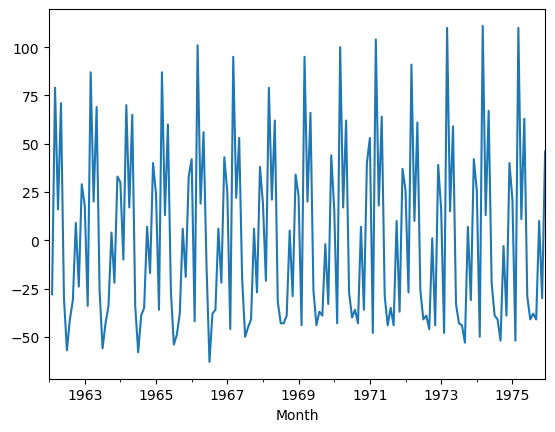

In [88]:
#become Stationnary 

df['First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

df['First Difference'].plot()
plt.show()

In [67]:
adf_check(df['First Difference'].dropna())

Augmented Dicky Fuller test
ADF test statistics:-3.0549955586530544
p-value:0.03006800400178694
# of lags:14
Num of observations used:152
strong evidence against null hyposthesis
reject null hypothesis
data has no unit root and i stationary


In [71]:
#if still wasnt stationary

df['Milk second difference'] = df['First Difference'] - df['First Difference'].shift(1)

adf_check(df['Milk second difference'].dropna())


Augmented Dicky Fuller test
ADF test statistics:-14.327873645603358
p-value:1.1126989332082506e-26
# of lags:11
Num of observations used:154
strong evidence against null hyposthesis
reject null hypothesis
data has no unit root and i stationary


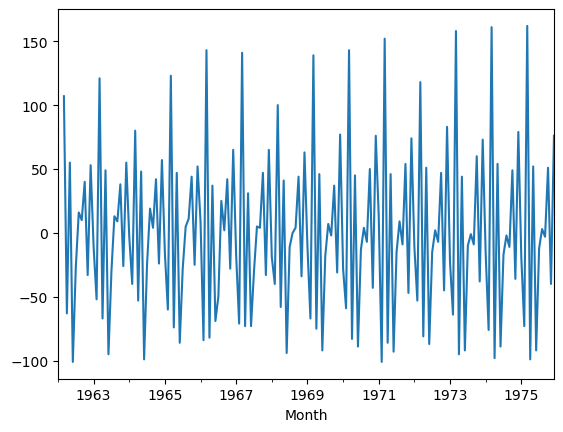

In [72]:
df['Milk second difference'].plot()
plt.show()

In [73]:
df['Seasonal difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)

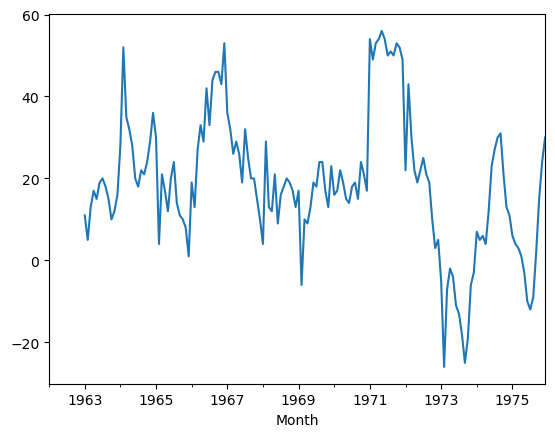

In [74]:
df['Seasonal difference'].plot()
plt.show()

In [75]:
adf_check(df['Seasonal difference'].dropna())


Augmented Dicky Fuller test
ADF test statistics:-2.3354193143593953
p-value:0.1607988052771142
# of lags:12
Num of observations used:143
weak evidence against null hypothesis
fail to reject null hypothesis
data has a unit root, it is non-stationary


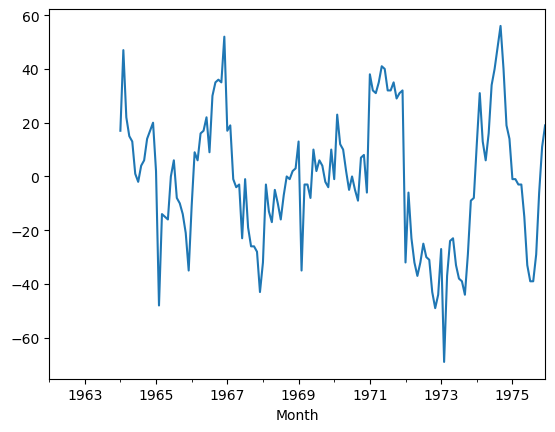

In [80]:
df['Seasonal First difference'] = df['Seasonal difference'] - df['Seasonal difference'].shift(12)
df['Seasonal First difference'].plot()
plt.show()

In [81]:
adf_check(df['Seasonal First difference'].dropna())

Augmented Dicky Fuller test
ADF test statistics:-2.636926405600833
p-value:0.0856029311804864
# of lags:12
Num of observations used:131
weak evidence against null hypothesis
fail to reject null hypothesis
data has a unit root, it is non-stationary


In [82]:
df['Seasonal Second sifference'] = df['Seasonal First difference'] - df['Seasonal First difference'].shift(12)
adf_check(df['Seasonal Second sifference'].dropna())

Augmented Dicky Fuller test
ADF test statistics:-2.9268463611348525
p-value:0.04231401519178814
# of lags:12
Num of observations used:119
strong evidence against null hyposthesis
reject null hypothesis
data has no unit root and i stationary


In [142]:
#step 3 : Autocorrelation and partial autocorrelation plots

#autocorrelation acf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

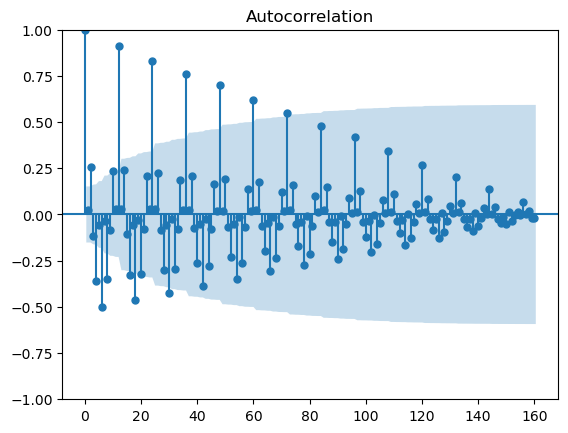

In [118]:
fig_first = plot_acf(df['First Difference'].dropna(), lags=160)
plt.show()

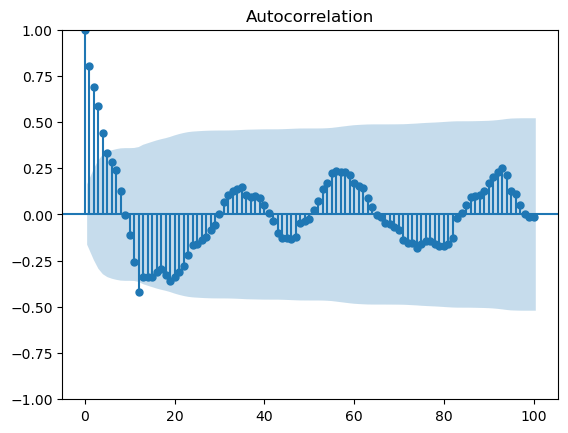

In [122]:
fig_seasonal_first = plot_acf(df['Seasonal First difference'].dropna(), lags=100)
plt.show()

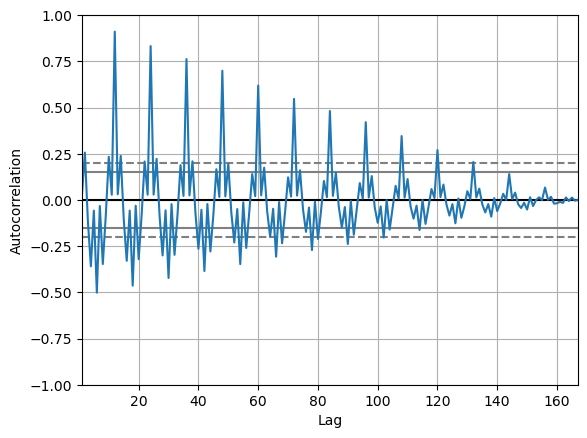

In [109]:
#autocorelation with pandas

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['First Difference'].dropna())
plt.show()

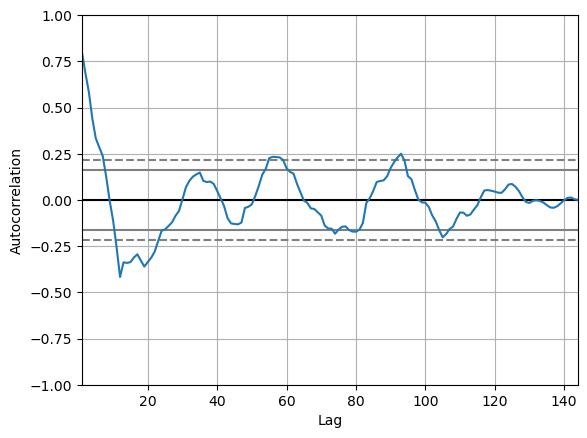

In [105]:
autocorrelation_plot(df['Seasonal First difference'].dropna())
plt.show()

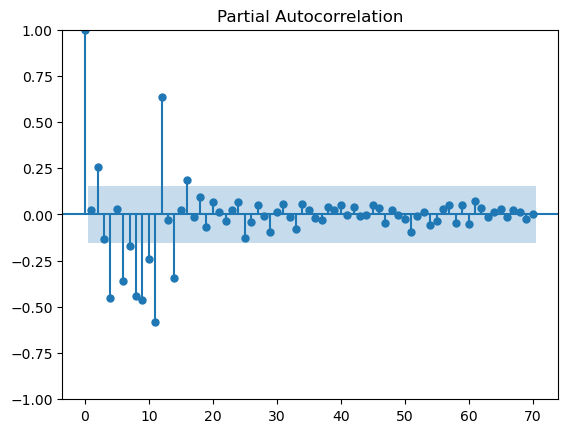

In [129]:
#partial autocorrelation pacf

result = plot_pacf(df['First Difference'].dropna(), lags =70)
plt.show()

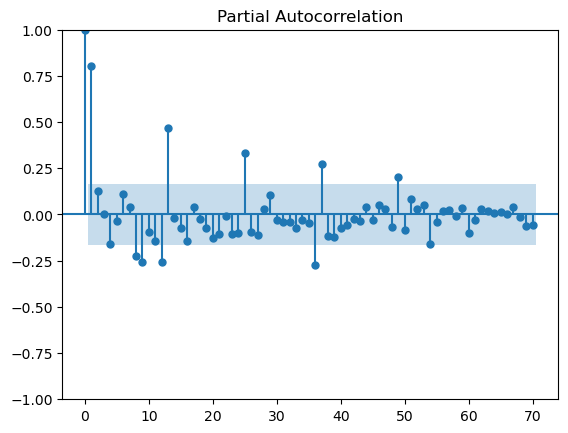

In [133]:
result = plot_pacf(df['Seasonal First difference'].dropna(), lags =70)
plt.show()

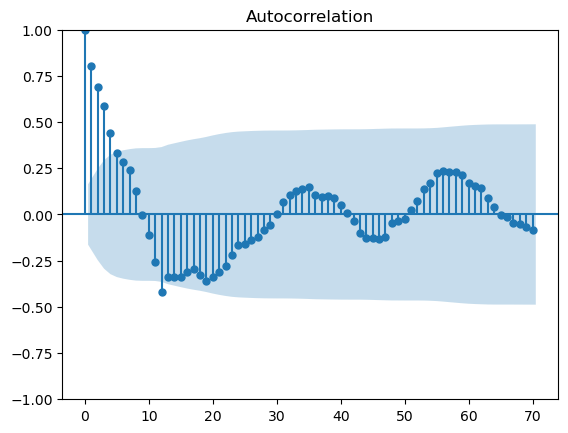

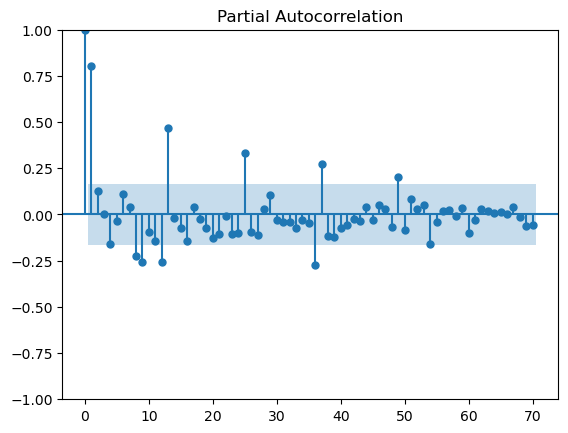

In [141]:
plot_acf(df['Seasonal First difference'].dropna(), lags=70)
plot_pacf(df['Seasonal First difference'].dropna(), lags=70)
plt.show()

In [144]:
#4 ARIMA model

from statsmodels.tsa.arima_model import ARIMA

In [145]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(*args, **kwargs)
 |
 |  ARIMA has been deprecated in favor of the new implementation
 |
 |  See Also
 |  --------
 |  statsmodels.tsa.arima.model.ARIMA
 |      ARIMA models with a variety of parameter estimators
 |  statsmodels.tsa.statespace.SARIMAX
 |      SARIMAX models estimated using MLE
 |
 |  Method resolution order:
 |      ARIMA
 |      ARMA
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from ARMA:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [149]:
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'], order=(0,1,0), seasonal_order=(1,1,1,12))

C:\Users\Utilisateur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Utilisateur\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [151]:
results = model.fit()

In [152]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:               Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Sun, 08 Feb 2026   AIC                           1074.131
Time:                                      17:06:51   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.58

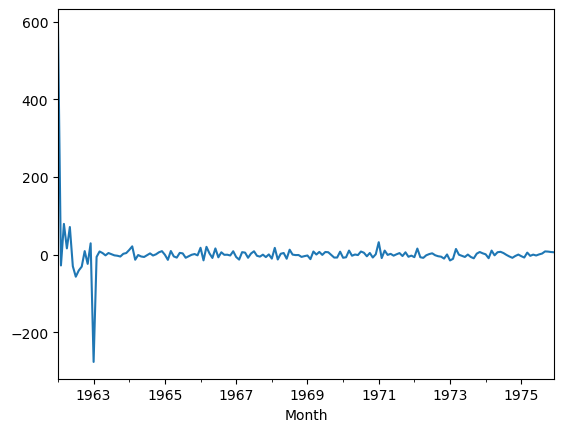

In [155]:
results.resid.plot()
plt.show()

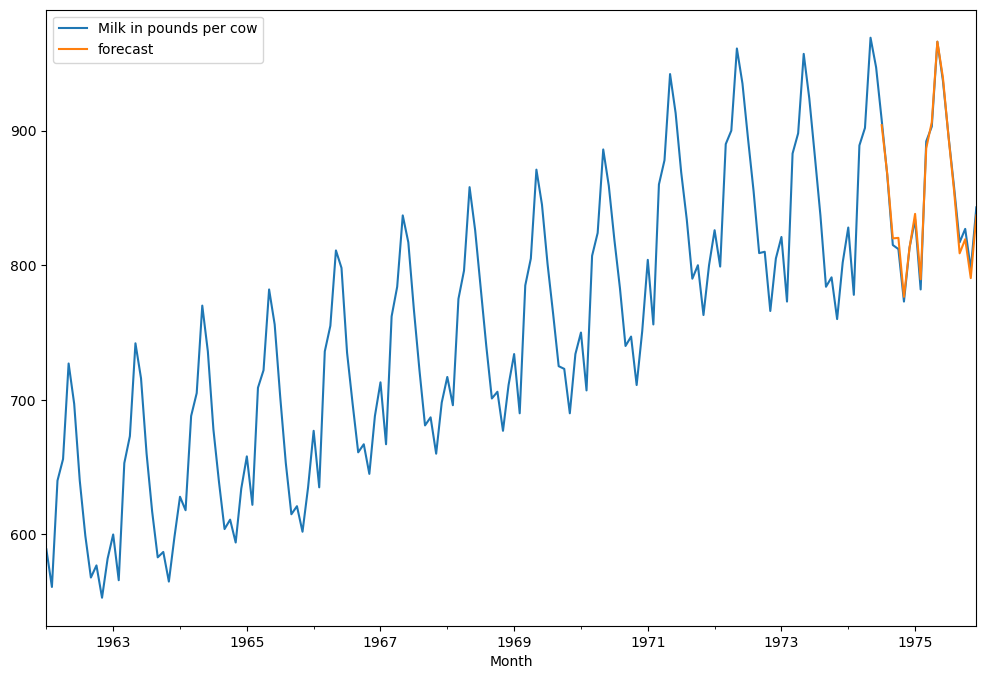

In [156]:
#step 5  : predictions sur des valeurs ancienne qu'on connait deja 

df['forecast'] = results.predict(start=150, end=168)
df[['Milk in pounds per cow', 'forecast']].plot(figsize=(12,8))
plt.show()

In [158]:
#predictions dans le futur

df.tail()

,Milk in pounds per cow,First Difference,Milk second difference,Seasonal difference,Seasonal First difference,Seasonal Second sifference,forecast
Month,,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,-39.0,-87.0,855.358648
1975-09-01,817.0,-41.0,-3.0,2.0,-29.0,-85.0,808.841372
1975-10-01,827.0,10.0,51.0,15.0,-6.0,-46.0,819.323185
1975-11-01,797.0,-30.0,-40.0,24.0,11.0,-8.0,790.427530
1975-12-01,843.0,46.0,76.0,30.0,19.0,5.0,837.063622


In [159]:
from pandas.tseries.offsets import DateOffset

In [162]:
#creation de dates futures

future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24)]
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [166]:
#creation de la dataframe avec les dates futures en index

future_df = pd.DataFrame(index=future_dates, columns=df.columns)
future_df.head()

,Milk in pounds per cow,First Difference,Milk second difference,Seasonal difference,Seasonal First difference,Seasonal Second sifference,forecast
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
#concat des df passees et futures

final_df = pd.concat([df, future_df])
final_df.tail()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_23352\3356126190.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([df, future_df])


,Milk in pounds per cow,First Difference,Milk second difference,Seasonal difference,Seasonal First difference,Seasonal Second sifference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
final_df['forecast'] = results.predict(start=168, end=192)
final_df.tail()

,Milk in pounds per cow,First Difference,Milk second difference,Seasonal difference,Seasonal First difference,Seasonal Second sifference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN,951.525867
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN,911.918957
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN,865.881182
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN,871.027295
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN,836.962996


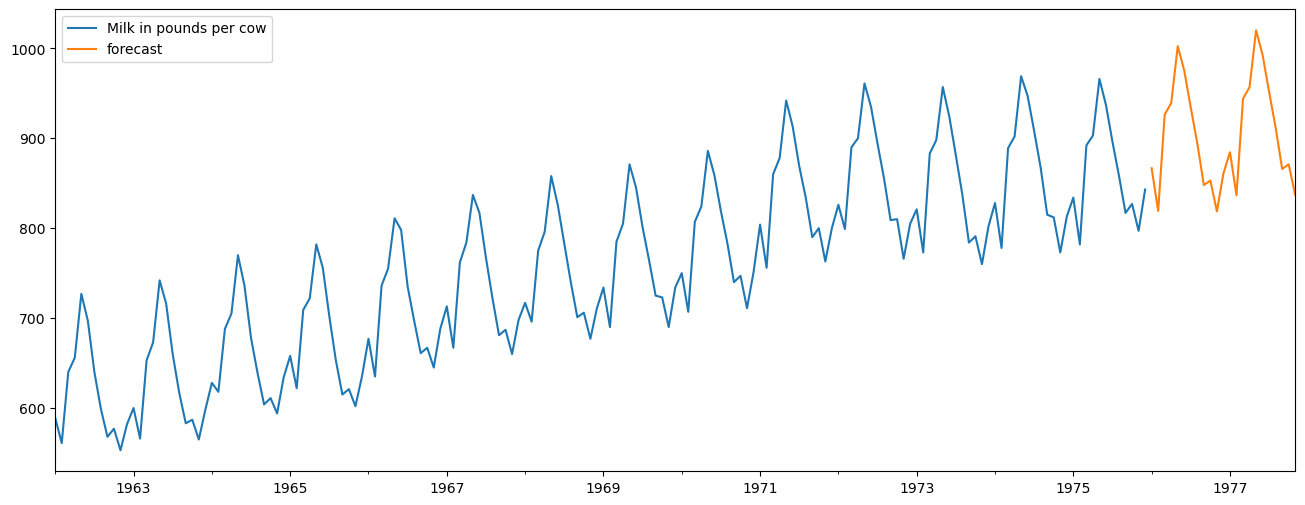

In [174]:
#prediction finale 

final_df['Milk in pounds per cow'].plot(figsize=(16,6))
final_df['forecast'].plot()
plt.legend()
plt.show()

In [176]:
#ca ne marche pas avec les stock market data parce qu'ils suivent un mvt brownien